> Adapted from kpp

A related approach would be doing the above but comparing the model weights more directly, either in Euclidean space (e.g., Frobenius norm) or in a latent space (PCA, CCA, autoencoders, etc., just trying to find a more structured latent space to compare model weights), and use a similar minimum similarity threshold for defining edges in the graph. 

In [1]:
import pandas as pd
import pickle
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import CCA
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GroupShuffleSplit
import matplotlib.pyplot as plt

In [2]:
#11/5: cca is unsup. for expert: fit in X_expert, X_other instead of y



#10/29. do PCA instead of CCA without expert user. should take same inputs. figure out what structure needed to effectively run PCA
##### try LDA or SVC instead of KNN 





#10/22
#do fft on data prior to working with it
#fft: time to freq
#ifft: freq to time
#where they have EMG, it should be each gesture indiv. pull in the data as the dataframe with each column
#look at kai's github for breaking down pickle into gestures

#check the directory structure of momona's code

#time data going in the moments and time converted to freq should have the same moments.

In [3]:
#stand_path = 'C:\\Users\\User\\Downloads\\Momona Data\\NEWmetadata_EMG_standardized_allusers.pkl'
pers_path = 'C:\\Users\\kdmen\\Box\\Meta_Gesture_2024\\saved_datasets\\filtered_datasets\\$BStand_EMG_df.pkl'

# Open the file in binary mode and load the data
with open(pers_path, 'rb') as file:
    EMG_pers = pickle.load(file)
    
#with open(stand_path, 'rb') as file:
#    EMG_stand = pickle.load(file)
    
#print(EMG_stand.shape)
print(EMG_pers.shape)

(204800, 19)


# Feature Engineering

In [4]:
def zero_order(df_freq):
    zero_order_moments_log = []
    zero_order_moments_raw = []

    for sensor in df_freq.columns:
        # Extract the frequency domain data for the sensor (column of the dataframe)
        time_data = df_freq[sensor].values
        
        # Step 1: Square the signal (power) at each frequency
        signal_squared = np.abs(time_data) ** 2
        
        # Step 2: Integrate (sum) the squared values to get the total power
        total_power = np.sum(signal_squared)
        
        # Step 3: Take the logarithm of the total power
        log_total_power = np.log(total_power)
        
        # Store the result in the dictionary
        zero_order_moments_log.append(log_total_power)
        zero_order_moments_raw.append(total_power)
        
    return zero_order_moments_log, zero_order_moments_raw


In [5]:
def first_order(df_freq, zero_order_raw):
    # Initialize lists to store the results for each sensor
    first_order_moments_log = []
    first_order_moments_raw = []
    
    for i,sensor in enumerate(df_freq.columns):
        # Extract the frequency domain data for the sensor (column of the dataframe)
        time_data = df_freq[sensor].values
        
        # Step 1: Take first derivative
        first_deriv = np.gradient(time_data)
        
        # Step 2: Square the signal (power) at each frequency of the first deriv
        signal_squared = np.abs(first_deriv) ** 2
        
        # Step 3: Integrate (sum) the squared values to get the total power
        total_power = np.sum(signal_squared)
        
        # Step 4: Take the logarithm of the total power
        log_total_power = np.log(total_power / (zero_order_raw[i]**2))
        
        # Store the results in the lists
        first_order_moments_log.append(log_total_power)
        first_order_moments_raw.append(total_power)

    # Convert lists to numpy arrays for consistency
    first_order_moments_log = np.array(first_order_moments_log)
    first_order_moments_raw = np.array(first_order_moments_raw)
    
    return first_order_moments_log, first_order_moments_raw


In [6]:
def second_order(df_freq, zero_order_raw):
    second_order_log = []
    second_order_raw = []

    for i, sensor in enumerate(df_freq.columns):
        # Extract the time domain data for the sensor (column of the dataframe)
        time_data = df_freq[sensor].values
        
        # Step 1: Take first derivative
        first_deriv = np.gradient(time_data)
        
        #Step 2: take second derivative
        second_deriv = np.gradient(first_deriv)
        
        # Step 3: Square the signal (power) at each frequency of the first deriv
        signal_squared = np.abs(second_deriv) ** 2
        
        # Step 4: Integrate (sum) the squared values to get the total power
        total_power = np.sum(signal_squared)
        
        # Step 4: Take the logarithm of the total power
        log_total_power = np.log(total_power/(zero_order_raw[i]**4))
        
        # Store the result in the dictionary
        second_order_log.append(log_total_power)
        second_order_raw.append(total_power)

    
    return second_order_log, second_order_raw


In [7]:
#working version of third_order that has precautions so no neg values inside log
def third_order(second_order_raw, first_order_raw, zero_order_raw):
    second_order_raw = np.array(second_order_raw)
    first_order_raw = np.array(first_order_raw)
    zero_order_raw = np.array(zero_order_raw)
    
    # Step 1: Compute the square roots (ensure no negative values before sqrt)
    sqrt_first_diff = np.sqrt(np.maximum(zero_order_raw - first_order_raw, 1e-10))  # Handle small or negative values
    sqrt_second_diff = np.sqrt(np.maximum(zero_order_raw - second_order_raw, 1e-10))  # Handle small or negative values
    
    # Step 2: Perform the dot product (ensure no division by zero by adding a small constant)
    dot_product = np.dot(sqrt_first_diff, sqrt_second_diff)
    dot_product = max(dot_product, 1e-10)  # Avoid division by zero or extremely small numbers
    
    # Step 3: Compute the sparseness ratio (ensure the result is positive)
    sparseness = zero_order_raw / dot_product
    
    # Step 4: Logarithm of the sparseness (ensure no negative or zero values inside the log)
    # We use np.maximum to ensure all values are at least 1e-10 to avoid taking log of non-positive values.
    safe_sparseness = np.maximum(sparseness, 1e-10)
    
    #print("Safe sparseness:", safe_sparseness)
    
    # Step 5: Apply the logarithm for third-order moments
    third_order_moments_log = np.log(safe_sparseness)
    
    return third_order_moments_log


In [8]:
def fourth_order(df_freq, zero_order_raw, first_order_raw, second_order_raw):
    # Initialize a list to store the fourth-order moments log for each sensor
    fourth_order_moments_logs = []
    
    for i,sensor in enumerate(df_freq.columns):
        # Extract the time domain data for the sensor (column of the dataframe)
        time_data = df_freq[sensor].values
        
        # Step 1: Take first derivative
        first_deriv = np.gradient(time_data)
        
        # Step 2: Absolute value of the signal (power) at each frequency of the first derivative
        signal_abs = np.abs(first_deriv)
        
        # Step 3: Integrate (sum) the absolute values to get the total power
        total_power = np.sum(signal_abs)
        
        # Step 4: Compute the fourth-order moments log for this sensor
        moment_log = np.log(np.sqrt((first_order_raw[i]**2) / 
                           (zero_order_raw[i] * second_order_raw[i])) / total_power)
        
        # Store the result in the list
        fourth_order_moments_logs.append(moment_log)
    
    # Convert list to numpy array for consistency
    fourth_order_moments_logs = np.array(fourth_order_moments_logs)
    
    return fourth_order_moments_logs


In [9]:
def create_feature_vectors(group):
    result_vector = []
    #can only run features on EMG columns
    emg_columns = [col for col in group.columns if col.startswith('EMG')]
    
    for emg_col in emg_columns:
        data = group[[emg_col]] #run on EMG columns. convert to df with single column to run with all the features
        
        #zero-order
        zero_order_log, zero_order_raw = zero_order(data)
        result_vector.append(zero_order_log)
        
        #first-order
        first_order_log, first_order_raw = first_order(data, zero_order_raw)
        result_vector.append(first_order_log)
        
        #second-order
        second_order_log, second_order_raw = second_order(data, zero_order_raw)
        result_vector.append(second_order_log)
        
        #third-order
        third_order_log = third_order(second_order_raw, first_order_raw, zero_order_raw)
        result_vector.append(third_order_log)
        
        #fourth-order
        fourth_order_log = fourth_order(data, zero_order_raw, first_order_raw, second_order_raw)
        result_vector.append(fourth_order_log)
        
    return pd.DataFrame({
        'Participant': [group['Participant'].iloc[0]],
        'Gesture_ID': [group['Gesture_ID'].iloc[0]],
        'Gesture_Num': [group['Gesture_Num'].iloc[0]],
        'feature': [np.array(result_vector)]
    })


In [10]:
#result = EMG_stand.groupby(['Participant', 'Gesture_ID', 'Gesture_Num']).apply(create_feature_vectors)
#output is df with particpant, gesture_ID, gesture_num and feature (holds 80 len vector)
#result = result.reset_index(drop=True)

In [11]:
userdef = EMG_pers.groupby(['Participant', 'Gesture_ID', 'Gesture_Num']).apply(create_feature_vectors)
#output is df with particpant, gesture_ID, gesture_num and feature (holds 80 len vector)
userdef = userdef.reset_index(drop=True)

In [12]:
#confirmed that all vectors are the same length (80)
for i in range(40):
    print(len(userdef['feature'].loc[i]))

80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80


In [13]:
print(userdef.shape)
userdef.head()

(3200, 4)


,Participant,Gesture_ID,Gesture_Num,feature
0,P004,close,1,"[[6.079045311063784], [-7.551458873254243], [-..."
1,P004,close,10,"[[5.994789910363704], [-7.978871468164499], [-..."
2,P004,close,2,"[[6.010193380499154], [-7.7063875553339], [-20..."
3,P004,close,3,"[[5.8212078257286874], [-7.463908156909893], [..."
4,P004,close,4,"[[5.974675085061773], [-7.945111601415482], [-..."


# CCA

In [14]:
#convert Gesture_ID to numerical with new Gesture_Encoded column

label_encoder = LabelEncoder()
userdef['Gesture_Encoded'] = label_encoder.fit_transform(userdef['Gesture_ID'])

In [15]:
#result['Gesture_Encoded'] = label_encoder.fit_transform(result['Gesture_ID'])

#count number of rows per PID
#result['Participant'].value_counts()
#userdef['Participant'].value_counts() #yay! all user-def are same length

#only keep participants with 50 rows (disabled and did all gestures)
#participant_counts = result['Participant'].value_counts()
# Filter participants who have exactly 50 rows
#with_disability = result[result['Participant'].isin(participant_counts[participant_counts == 50].index)].copy()
# Display the filtered dataset
#with_disability

CCA functions

In [16]:
# Hold out one participant as the expert
def hold_out_expert(data, participant_column):
    participant_ids = data[participant_column].unique()
    expert_user = np.random.choice(participant_ids)  # Randomly select one participant as expert
    data_expert = data[data[participant_column] == expert_user]  # Expert data
    data_remaining = data[data[participant_column] != expert_user]  # Remaining data
    return data_expert, data_remaining

In [17]:
# Train-test split for remaining data
#def split_train_test(data, participant_column, test_size=0.2):
#    participant_ids = data[participant_column].unique()
#    train_ids, test_ids = train_test_split(participant_ids, test_size=test_size, random_state=42)
    
#    train_data = data[data[participant_column].isin(train_ids)]
#    test_data = data[data[participant_column].isin(test_ids)]
    
#    return train_data, test_data

def split_train_test(X, y, data, participant_column, test_size=0.2, random_state=42):
    """
    Splits features and labels into training and testing sets based on participant IDs.

    Parameters:
        X (DataFrame or ndarray): Feature matrix.
        y (Series or ndarray): Target labels.
        groups (Series or ndarray): Grouping variable (e.g., participant IDs).
        test_size (float): Fraction of data to use as the test set.
        random_state (int): Random state for reproducibility.

    Returns:
        X_train, X_test, y_train, y_test: Split features and labels for training and testing.
    """
    # Initialize GroupShuffleSplit
    #participant_ids = data[participant_column].unique()
    #print(X.head())
    #print(y.head())
    splitter = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)

    # Perform the split
    for train_idx, test_idx in splitter.split(X, y, groups=participant_column):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

    return X_train, X_test, y_train, y_test


In [18]:
#with_disability = with_disability.reset_index(drop=True)
#with_disability.tail()
#split_train_test(with_disability['feature'], with_disability['Gesture_Encoded'], with_disability, with_disability['Participant'])

In [19]:
def flatten_features(feature_column):
    # Convert a column of lists of lists into a 2D NumPy array
    return np.array([np.array(item).flatten() for item in feature_column])

In [20]:
#inside k_fold function
# Apply CCA btwn expert and train/test
def apply_cca_between_expert_and_others(expert_data, other_data, target_column, n_components=2):
    # Separate features (X) and target (y)
    
    #after flattening to 2D 
    X_expert = flatten_features(expert_data['feature'])
    X_other = flatten_features(other_data['feature'])

    y_expert = expert_data[target_column]
    y_other = other_data[target_column]
    
    # Apply CCA between expert and other participant
    cca = CCA(n_components=n_components)
    #cca.fit(X_expert, y_expert)
    #print(X_expert.shape)
    #print(X_other.shape)
    cca.fit(X_expert, X_other) #might not run bcuz diff shapes
    #need to figure out how to pass in X_others. if not clear from paper, google cca github and try to find expert user and others
    X_other_cca = cca.transform(X_other)
    
    return X_other_cca, y_other#, X_expert, X_other#, X_other, X_expert, y_expert            think we're good to leave this out?

In [21]:
#inside k_fold function
# Run KNN -- used inside cca but can also be used outside
def run_knn(X_train, y_train, X_test, y_test, n_neighbors=5):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    
    return accuracy_score(y_test, y_pred)

In [22]:
# Implement k-fold cross-validation and refer to each of the other functions to run CCA between expert user and training and expert user and testing
def cca_knn(data, expert_data, participant_column, target_column, k=5, n_neighbors=5, n_components=2):

    group_kf = GroupKFold(n_splits=k)
    accuracies = []
    
    #80/20 train test split. 4 folds in train and 1 in test
    for train_index, test_index in group_kf.split(data, groups=data[participant_column]):
        # Split based on participant IDs
        train_ids = data[participant_column].iloc[train_index].unique()
        test_ids = data[participant_column].iloc[test_index].unique()
        
        train_data = data[data[participant_column].isin(train_ids)]
        test_data = data[data[participant_column].isin(test_ids)]
        
        #print("total data:", data.shape)
        #print("train", train_data[participant_column].unique())
        #print("Test", test_data[participant_column].unique())
        # CCA between expert and training users
        X_train_cca = []
        y_train = []
        for pid in train_ids:
            pid_data = train_data[train_data[participant_column] == pid]
            #print("participant id", pid)
            #print("expert data", expert_data.shape)
            #print("participant data", pid_data.shape)
            X_pid_cca, y_pid = apply_cca_between_expert_and_others(expert_data, pid_data, target_column, n_components)
            X_train_cca.append(X_pid_cca)
            y_train.append(y_pid)
        
        # Combine all CCA-transformed training data
        X_train_cca = np.vstack(X_train_cca)
        y_train = np.concatenate(y_train)
        
        # CCA between expert and testing users
        X_test_cca = []
        y_test = []
        for pid in test_ids:
            pid_data = test_data[test_data[participant_column] == pid]
            #change to X_expert, X_other for output     X_pid_cca, y_pid = apply_cca_between_expert_and_others(expert_data, pid_data, target_column, n_components)
            X_test_cca.append(X_pid_cca)
            y_test.append(y_pid)
        
        # Combine all CCA-transformed testing data
        X_test_cca = np.vstack(X_test_cca)
        y_test = np.concatenate(y_test)
        
        # Run KNN on CCA-transformed feature sets
        accuracy = run_knn(X_train_cca, y_train, X_test_cca, y_test, n_neighbors)
        accuracies.append(accuracy)
    
    return accuracies

In [23]:
#expert_data, remaining_data = hold_out_expert(with_disability, 'Participant')
#cca_knn_accuracy=cca_knn(remaining_data, expert_data, 'Participant', 'Gesture_Encoded', k=5, n_neighbors=5, n_components=2)
    

In [24]:
# Function to calculate and store results from cca and knn in a DataFrame
def calculate_mean_accuracies(data, label, iterations=100):
    results = {}
    
    for i in range(iterations):
        expert_data, remaining_data = hold_out_expert(data, 'Participant')
        cca_knn_accuracy = cca_knn(remaining_data, expert_data, 'Participant', 'Gesture_Encoded', k=5, n_neighbors=5, n_components=2)
        
        # Collect accuracies per participant
        participants = expert_data['Participant'].unique()
        for participant, accuracy in zip(participants, cca_knn_accuracy):
            if participant not in results:
                results[participant] = []
            results[participant].append(accuracy)
    
    # Calculate mean accuracies
    mean_accuracies = {participant: np.mean(accuracies) for participant, accuracies in results.items()}
    
    # Convert to DataFrame
    results_df = pd.DataFrame.from_dict(mean_accuracies, orient='index', columns=['Mean Accuracy'])
    results_df.reset_index(inplace=True)
    results_df.rename(columns={'index': 'Participant'}, inplace=True)
    results_df['Dataset'] = label  #between standardized or user-def
    
    return results_df


In [25]:
# Run for both datasets
#standardized_results_df = calculate_mean_accuracies(with_disability, 'Standardized', iterations=100)
userdef_results_df = calculate_mean_accuracies(userdef, 'User-Defined', iterations=100)

# Combine both results into a single DataFrame
#combined_results_df = pd.concat([standardized_results_df, userdef_results_df], ignore_index=True)
#sorted_results_df = combined_results_df.sort_values(by=['Dataset', 'Mean Accuracy'], ascending=[True, True])

#sorted_results_df.to_csv('cca_knn_results.csv', index=False)


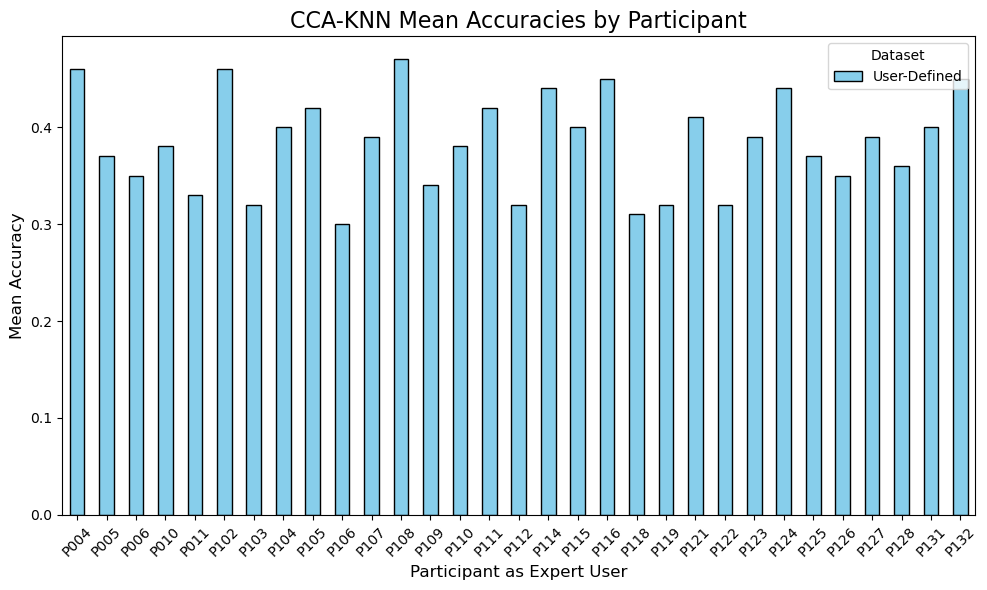

In [26]:
pivot_df = userdef_results_df.pivot(index="Participant", columns="Dataset", values="Mean Accuracy")

# Plot the bar chart
ax = pivot_df.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'orange'], edgecolor='black')

# Add labels and title
plt.title('CCA-KNN Mean Accuracies by Participant', fontsize=16)
plt.xlabel('Participant as Expert User', fontsize=12)
plt.ylabel('Mean Accuracy', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Dataset", fontsize=10)

# Adjust layout and display the chart
plt.tight_layout()
#plt.savefig('cca_knn_accuracies.jpg', format='jpg')

In [27]:
from sklearn.linear_model import SGDClassifier

# Function to run CCA and SGD on each fold
def cca_sgd(data, expert_data, participant_column, target_column, k=5, n_components=2):
    """
    Perform CCA between expert user data and participants' data, then train an SGD Classifier on the CCA-transformed features.
    
    Parameters:
        data (DataFrame): The complete dataset including 'Participant' and 'feature' columns.
        expert_data (DataFrame): The expert user data.
        participant_column (str): The name of the participant column.
        target_column (str): The name of the target column.
        k (int): The number of folds for Group K-Fold cross-validation.
        n_components (int): Number of components for CCA.

    Returns:
        accuracies (list): A list of accuracy scores from each fold of the cross-validation.
    """
    group_kf = GroupKFold(n_splits=k)
    accuracies = []
    
    # Perform 80/20 train-test split using Group K-Fold cross-validation
    for train_index, test_index in group_kf.split(data, groups=data[participant_column]):
        train_ids = data[participant_column].iloc[train_index].unique()
        test_ids = data[participant_column].iloc[test_index].unique()
        
        train_data = data[data[participant_column].isin(train_ids)]
        test_data = data[data[participant_column].isin(test_ids)]
        
        # CCA between expert and training users
        X_train_cca = []
        y_train = []
        for pid in train_ids:
            pid_data = train_data[train_data[participant_column] == pid]
            X_pid_cca, y_pid = apply_cca_between_expert_and_others(expert_data, pid_data, target_column, n_components)
            X_train_cca.append(X_pid_cca)
            y_train.append(y_pid)

        # Combine all CCA-transformed training data
        X_train_cca = np.vstack(X_train_cca)
        y_train = np.concatenate(y_train)

        # CCA between expert and testing users
        X_test_cca = []
        y_test = []
        for pid in test_ids:
            pid_data = test_data[test_data[participant_column] == pid]
            X_pid_cca, y_pid = apply_cca_between_expert_and_others(expert_data, pid_data, target_column, n_components)
            X_test_cca.append(X_pid_cca)
            y_test.append(y_pid)

        # Combine all CCA-transformed testing data
        X_test_cca = np.vstack(X_test_cca)
        y_test = np.concatenate(y_test)

        # Initialize the SGD Classifier and fit to the CCA-transformed features
        sgd = SGDClassifier(loss="log_loss", max_iter=1000, tol=1e-4)
        sgd.fit(X_train_cca, y_train)

        # Predict and evaluate using the test set
        y_pred = sgd.predict(X_test_cca)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    return accuracies



In [28]:
# Function to calculate and store results from CCA and SGD
def calculate_mean_accuracies_sgd(data, label, iterations=100):
    results = {}
    
    for i in range(iterations):
        expert_data, remaining_data = hold_out_expert(data, 'Participant')
        cca_sgd_accuracy = cca_sgd(remaining_data, expert_data, 'Participant', 'Gesture_Encoded', k=5, n_components=2)
        
        # Collect accuracies per participant
        participants = expert_data['Participant'].unique()
        for participant, accuracy in zip(participants, cca_sgd_accuracy):
            if participant not in results:
                results[participant] = []
            results[participant].append(accuracy)
    
    # Calculate mean accuracies
    mean_accuracies = {participant: np.mean(accuracies) for participant, accuracies in results.items()}
    
    # Convert to DataFrame
    results_df = pd.DataFrame.from_dict(mean_accuracies, orient='index', columns=['Mean Accuracy'])
    results_df.reset_index(inplace=True)
    results_df.rename(columns={'index': 'Participant'}, inplace=True)
    results_df['Dataset'] = label  # Standardized or User-Defined
    
    return results_df

In [29]:
# Run for both datasets
#standardized_results_df = calculate_mean_accuracies_sgd(with_disability, 'Standardized', iterations=100)
userdef_results_df = calculate_mean_accuracies_sgd(userdef, 'User-Defined', iterations=100)

# Combine both results into a single DataFrame
#combined_results_df = pd.concat([standardized_results_df, userdef_results_df], ignore_index=True)
#sorted_results_df = combined_results_df.sort_values(by=['Dataset', 'Mean Accuracy'], ascending=[True, True])
# Print results
#print(sorted_results_df)
#sorted_results_df.to_csv('cca_sgd_accuracies.csv', index = False)


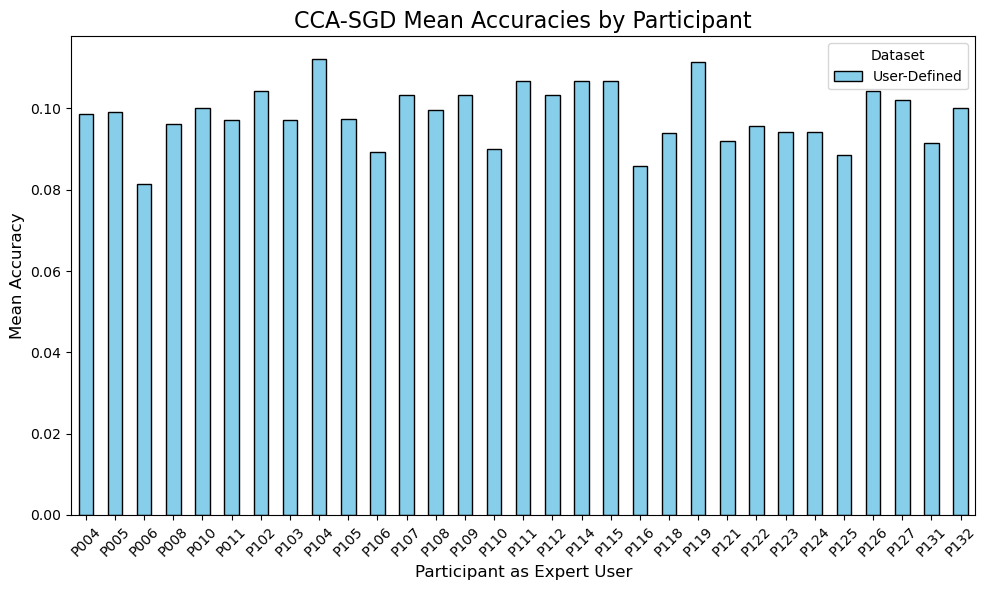

In [30]:
pivot_df = userdef_results_df.pivot(index="Participant", columns="Dataset", values="Mean Accuracy")

# Plot the bar chart
ax = pivot_df.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'orange'], edgecolor='black')

# Add labels and title
plt.title('CCA-SGD Mean Accuracies by Participant', fontsize=16)
plt.xlabel('Participant as Expert User', fontsize=12)
plt.ylabel('Mean Accuracy', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Dataset", fontsize=10)

# Adjust layout and display the chart
plt.tight_layout()
#plt.savefig('cca_sgd_accuracies.jpg', format='jpg')

In [31]:
def run_pca_knn(df, n_components=8, n_neighbors=5, k=5):
    """
    Perform PCA on the 'feature' column and KNN classification using Group K-Fold validation.

    Parameters:
        df (DataFrame): Input DataFrame containing 'feature', 'Gesture_ID', and 'Participant' columns.
        n_components (int): Number of PCA components.
        n_neighbors (int): Number of neighbors for KNN.
        k (int): Number of folds for Group K-Fold cross-validation.

    Returns:
        explained_variance_ratios (list): Explained variance ratio for PCA in each fold.
        accuracies (list): Classification accuracies for KNN on test sets in each fold.
    """
    # Flatten 'feature' column
    df['feature_flat'] = df['feature'].apply(lambda x: np.ravel(x))

    # Extract features and labels
    X = np.vstack(df['feature_flat'].values)
    y = df['Gesture_ID']
    groups = df['Participant']

    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Initialize PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)

    # Group K-Fold setup
    group_kf = GroupKFold(n_splits=k)
    accuracies = []
    explained_variance_ratios = []

    for train_index, test_index in group_kf.split(X_pca, y, groups=groups):
        # Split the data
        X_train, X_test = X_pca[train_index], X_pca[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Train KNN
        knn = KNeighborsClassifier(n_neighbors=n_neighbors)
        knn.fit(X_train, y_train)

        # Predict and evaluate
        y_pred = knn.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

        # Store explained variance ratio (same for all splits)
        explained_variance_ratios.append(pca.explained_variance_ratio_)

    return explained_variance_ratios, accuracies


In [32]:
#stand_explained_variance_ratios, stand_accuracies = run_pca_knn(df=with_disability, n_components=10, n_neighbors=5, k=5)
#print("PCA Explained Variance Ratios:", explained_variance_ratios)
#print("KNN Classification Accuracies:", accuracies)

user_explained_variance_ratios, user_accuracies = run_pca_knn(df=userdef, n_components=10, n_neighbors=5, k=5)
#print("PCA Explained Variance Ratios:", explained_variance_ratios)
#print("KNN Classification Accuracies:", accuracies)

In [33]:
#df_std = pd.DataFrame({
#    "Dataset": "Standardized",
#    "Fold": range(1, len(stand_accuracies) + 1),
#    "Accuracy": stand_accuracies,
#    "PCA Explained Variance Ratio": [list(ratios) for ratios in stand_explained_variance_ratios]
#})

df_userdef = pd.DataFrame({
    "Dataset": "User-Defined",
    "Fold": range(1, len(user_accuracies) + 1),
    "Accuracy": user_accuracies,
    "PCA Explained Variance Ratio": [list(ratios) for ratios in user_explained_variance_ratios]
})

#combined_df = pd.concat([df_std, df_userdef], ignore_index=True)
#sorted_df = combined_df.sort_values(by=["Dataset", "Fold"])
#print(sorted_df)
#sorted_df.to_csv("pca_knn_results.csv", index=False)

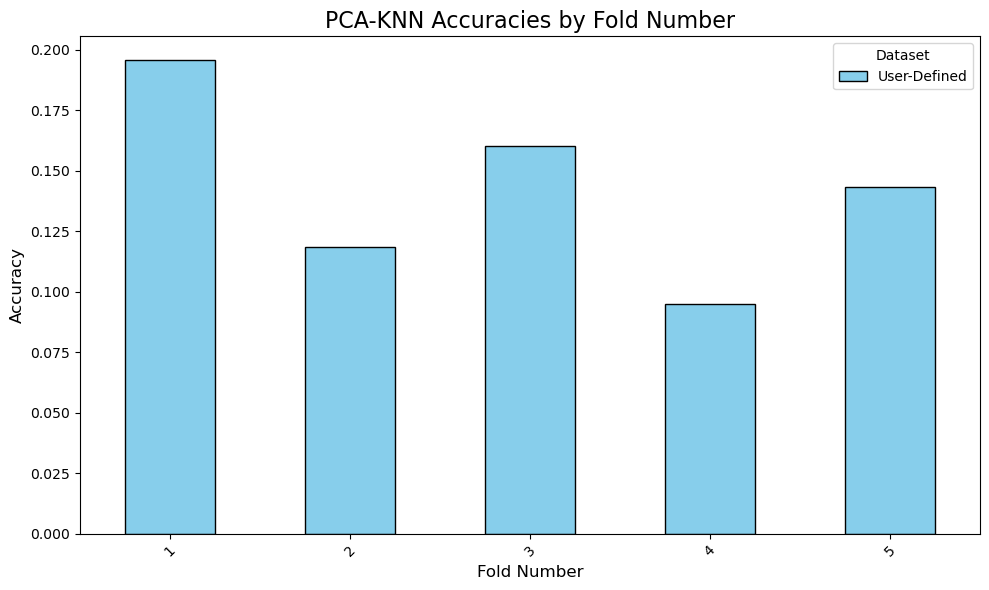

In [34]:
pivot_df = df_userdef.pivot(index="Fold", columns="Dataset", values="Accuracy")

# Plot the bar chart
ax = pivot_df.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'orange'], edgecolor='black')

# Add labels and title
plt.title('PCA-KNN Accuracies by Fold Number', fontsize=16)
plt.xlabel('Fold Number', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Dataset", fontsize=10)

# Adjust layout and display the chart
plt.tight_layout()
#plt.savefig('pca_knn_accuracies.jpg', format='jpg')

In [35]:
def run_knn_baseline_with_group_kfold(data, expert_data, remaining_data, target_column, n_neighbors=5, k=5):
    """
    Perform KNN classification with Group K-Fold cross-validation using a combination of expert and remaining data.

    Parameters:
        data (DataFrame): Full dataset for reference (includes 'Participant' column for grouping).
        expert_data (DataFrame): Expert user data.
        remaining_data (DataFrame): Remaining participant data.
        target_column (str): Column name for the target labels.
        n_neighbors (int): Number of neighbors for KNN.
        k (int): Number of folds for Group K-Fold cross-validation.

    Returns:
        accuracies (list): List of classification accuracies for each fold.
    """
    # Flatten the features from both datasets
    X_expert = flatten_features(expert_data['feature'])
    X_remaining = flatten_features(remaining_data['feature'])
    
    # Combine the feature sets and their corresponding targets
    X_combined = np.vstack((X_expert, X_remaining))
    y_expert = expert_data[target_column].values
    y_remaining = remaining_data[target_column].values
    y_combined = np.concatenate((y_expert, y_remaining))

    # Combine participant IDs
    participant_ids_expert = expert_data['Participant'].values
    participant_ids_remaining = remaining_data['Participant'].values
    participant_ids_combined = np.concatenate((participant_ids_expert, participant_ids_remaining))
    
    # Group K-Fold setup
    group_kf = GroupKFold(n_splits=k)
    accuracies = []

    for train_index, test_index in group_kf.split(X_combined, y_combined, groups=participant_ids_combined):
        # Split the data
        X_train, X_test = X_combined[train_index], X_combined[test_index]
        y_train, y_test = y_combined[train_index], y_combined[test_index]

        # Train KNN
        knn = KNeighborsClassifier(n_neighbors=n_neighbors)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
    
    return accuracies

